-------------------------------------------------------------------
**TD DSA 2021 de Antoine Ly   -   rapport de Fabien Faivre**
-------------------------     -------------------------------------

# Analyse descriptive

## Setup

In [5]:
!pip install textblob

In [6]:
!pip install emot

In [7]:
!pip install wordcloud

In [8]:
#Temps et fichiers
import os
import warnings
import time
from datetime import timedelta

#Manipulation de données
import pandas as pd
import numpy as np


# Text
from collections import Counter
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.util import ngrams

from textblob import TextBlob
import string
import re
import spacy 
from emot.emo_unicode import UNICODE_EMO, EMOTICONS


#Visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud

#Tracking d'expérience
import mlflow
import mlflow.sklearn

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Utilisation du package

In [9]:
#Cette cellule permet d'appeler la version packagée du projet et d'en assurer le reload avant appel des fonctions
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from dsa_sentiment.scripts.make_dataset import load_data
from dsa_sentiment.scripts.evaluate import eval_metrics
from dsa_sentiment.scripts.make_dataset import Preprocess_StrLower, Preprocess_transform_target

### Configuration de l'experiment MLFlow

In [11]:
mlflow.tracking.get_tracking_uri()

'/mnt/experiments'

### Chargement des données

In [12]:
# On Importe les données

#df
df_train=pd.read_parquet('/mnt/data/interim/df_train.gzip')
df_val=pd.read_parquet('/mnt/data/interim/df_val.gzip')
df_test=pd.read_parquet('/mnt/data/interim/df_test.gzip')

#X
X_train=pd.read_parquet('/mnt/data/interim/X_train.gzip')
X_val=pd.read_parquet('/mnt/data/interim/X_val.gzip')
X_test=pd.read_parquet('/mnt/data/interim/X_test.gzip')

#y
y_train=pd.read_parquet('/mnt/data/interim/y_train.gzip')
y_val=pd.read_parquet('/mnt/data/interim/y_val.gzip')
y_test=pd.read_parquet('/mnt/data/interim/y_test.gzip')

## EDA

On commence par nalyser l'équilibre des différentes classes de sentiments

In [13]:
df = df_train
df.head()

text sentiment
0                I`d have responded, if I were going   neutral
1      Sooo SAD I will miss you here in San Diego!!!  negative
2                          my boss is bullying me...  negative
3                     what interview! leave me alone  negative
4   Sons of ****, why couldn`t they put them on t...  negative

### Analyse de l'équilibre du jeu d'entrainement par label

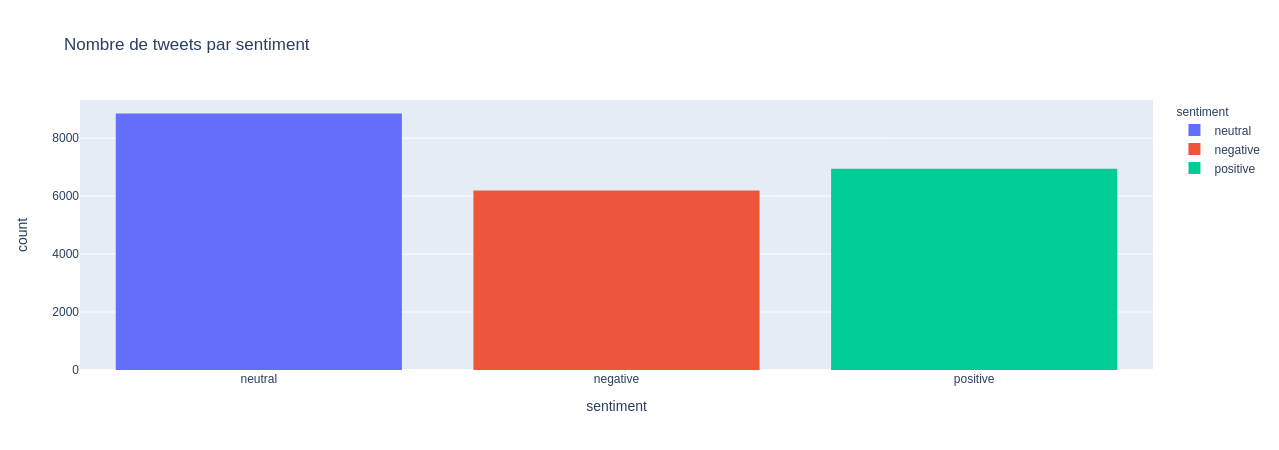

In [14]:
fig = px.histogram(df, x="sentiment", color="sentiment", title = 'Nombre de tweets par sentiment')
fig.show()

Il existe un léger déséquilibre dans les classes en faveur des sentiments `neutral`

### Analyse des champs lexicaux par label

Pour la suite des travaux, on créée un corpus contenant la concaténation de tous les tweets d'une certaine tonalité.

In [15]:
def create_corpus(text_series):
    text = text_series.apply(lambda x : x.split())
    text = sum(text, [])
    return text
    

In [16]:
positive_text = create_corpus(df['text'][df['sentiment']=='positive'])
negative_text = create_corpus(df['text'][df['sentiment']=='negative'])
neutral_text = create_corpus(df['text'][df['sentiment']=='neutral'])


Il devient alors possible de crééer des histogrammes représentant la fréquence de N-grams dans un corpus =donné

In [17]:
def plot_freq_dist(text_corpus, nb=30, ngram=1, title=''):
    '''
    Plot the most common words
    
    inputs:
        text_corpus : a corpus of words
        nb : number of words to plot
        title : graph title
    
    returns:
        nothing, plots the graph
    
    '''

    freq_pos=Counter(ngrams(create_corpus(pd.Series(text_corpus)),ngram))
    pos_df = pd.DataFrame({
        "words":[' '.join(items) for items in list(freq_pos.keys())],
        "Count":list(freq_pos.values())
    })
    common_pos= pos_df.nlargest(columns="Count", n=30)

    fig = px.bar(common_pos, x="words", y="Count", labels={"words": "Words", "Count":"Frequency"}, title=title)
    fig.show();

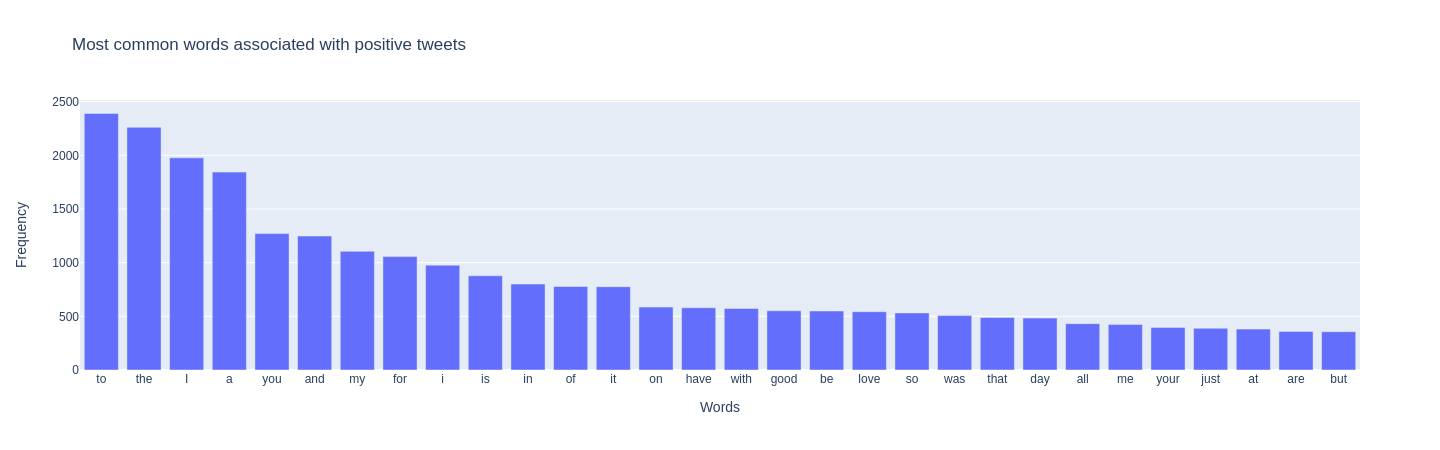

In [18]:
plot_freq_dist(positive_text, title = 'Most common words associated with positive tweets')

Le résultat montre la prépondérance des `stopwords`, ces mots d'articulation, qui sont très communs et gènent l'identifiaction de mots clefs propres à un document / ensemble de documents spécifiques.

Il convient donc d'effectuer des opérations de retraitement du texte pour analyse. 

### Preprocessing

Parmi les éléments propres aux tweets qui peuvent avoir un impact sur la suite on compte :

 - les mots clefs marqués par un `#`
 - les noms d'utilisateurs commençant par un `@`
 - les emoticons et emojis
 - les nombre de mots en MAJUSCULES
 - la répétition de caractères pour marquer l'emphase `!!!!`, `looooong`, ou l'autocensure `f***`
 - les fautes de frappes (mots de moins de 2 caractères)

Afin de disposer de traitements homogènes, repoductibles et paramétrables, une fonction spécifique est créée. Les différenst paramètres pourront être testés dans les phase de modélistaion ultérieures.

source [preprocess](https://www.kaggle.com/stoicstatic/twitter-sentiment-analysis-for-beginners)

In [57]:
def preprocess_text(text_series, 
                    apply_lemmatizer=True,
                    apply_lowercase=True,
                    apply_url_standerdisation=True,
                    apply_user_standerdisation=True,
                    apply_emoticon_to_words=True,
                    apply_stopwords_removal=True,
                    apply_shortwords_removal=True,
                    apply_non_alphabetical_removal=True,
                    apply_only_2_consecutive_charac=True
                   
                   ):
    '''
    Main preprocess function
    
    inputs:
        text_series : a pandas Series object with text to preprocess
    
    outputs:
        a preprocessed pandas Series object
    '''
    
    processedText = []
    
    if apply_lemmatizer:
        # Create Lemmatizer and Stemmer.
        wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = r"[^(\w|\*|(!){2}|#)]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in text_series:
        
        if apply_lowercase:
            tweet = tweet.lower()
        
        if apply_url_standerdisation:
            # Replace all URls with 'URL'
            tweet = re.sub(urlPattern,' URL',tweet)
        
        if apply_user_standerdisation:
            # Replace @USERNAME to 'USER'.
            tweet = re.sub(userPattern,' USER', tweet)  
        
        if apply_emoticon_to_words:
            # Replace all emojis.
            for emo in EMOTICONS:
                #refactor outputs so that we come up with a single word when/if text spliting afterwards
                val = "_".join(EMOTICONS[emo].replace(",","").split())
                val='EMO_'+val
                tweet = tweet.replace(emo, ' '+val+' ')

            for emot in UNICODE_EMO:
                val = "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split())
                val='EMO_'+val
                tweet = tweet.replace(emo, ' '+val+' ')
      
        if apply_only_2_consecutive_charac:
            # Replace 3 or more consecutive letters by 2 letter.
            tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        if apply_non_alphabetical_removal:
            # Replace all non alphabets.
            tweet = re.sub(alphaPattern, " ", tweet)
        

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            if apply_stopwords_removal: 
                if word in stopwords.words('english'):
                    word=''
            else:
                word=word
            #if word not in stopwordlist:
            if apply_shortwords_removal:
                if len(word)<=1:
                    word=''
            else:
                word=word
            # Lemmatizing the word.
            if apply_lemmatizer:
                word = wordLemm.lemmatize(word)
            else:
                word=word
            
            tweetwords += (word+' ')

        processedText.append(tweetwords)
        
    return processedText


In [20]:
positive_text_prepro = preprocess_text(df['text'][df['sentiment']=='positive'], apply_lemmatizer=False, apply_non_alphabetical_removal=True)

In [56]:
pd.Series(positive_text_prepro).head()

0           2am feedings   baby  fun     smiles  coos 
1    journey! wow   became cooler hehe (is  possibl...
2     really really like  song love story  taylor s...
3    playing ghost online  really interesting  new ...
4             free fillin app   ipod  fun im addicted 
dtype: object

In [21]:
neutral_text_prepro = preprocess_text(df['text'][df['sentiment']=='neutral'], apply_lemmatizer=False, apply_non_alphabetical_removal=True)

In [58]:
pd.Series(neutral_text_prepro).head()

0                                  responded    going 
1    URL  shameless plugging   best rangers forum  ...
2                                            soo high 
3                                                     
4     much   love   hopeful  reckon  chances  minim...
dtype: object

In [22]:
negative_text_prepro = preprocess_text(df['text'][df['sentiment']=='negative'], apply_lemmatizer=False, apply_non_alphabetical_removal=True)

In [59]:
pd.Series(negative_text_prepro).head()

0                   soo sad   miss    san diego!! 
1                                 boss  bullying  
2                         interview! leave  alone 
3    sons  **     put    releases  already bought 
4           sharpie  running dangerously low  ink 
dtype: object

### Analyses des mots clefs des tweets positifs

La fonction suivante permettra de réaliser des nuages de mots à partir d'un corpus

In [23]:
def plotWc(text, stopwords=None, title=''):
    wc = WordCloud(
            stopwords=stopwords,
            width=800,
            height=400,
            max_words=1000,
            random_state=44,
            background_color="white",
            collocations=False
    ).generate(text)
    
    plt.figure(figsize = (10,10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

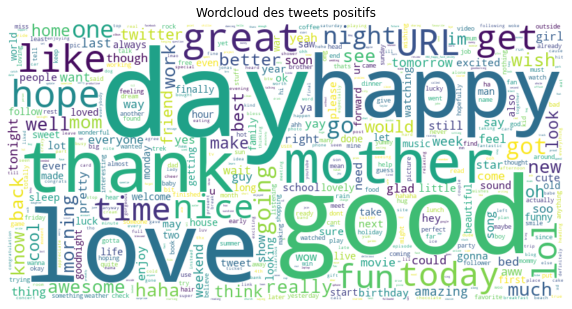

In [24]:
plotWc(" ".join(positive_text_prepro), stopwords=stopwords.words('english'), title = "Wordcloud des tweets positifs")

Les tweets positpositive_text_prepro marqués par la forte reprétsentation de mots à connotation positive `love`, `good`, `happy`.

Cet a priori graphique peut être confirmé par un graphique de fréquence des mots individuels les plus présents

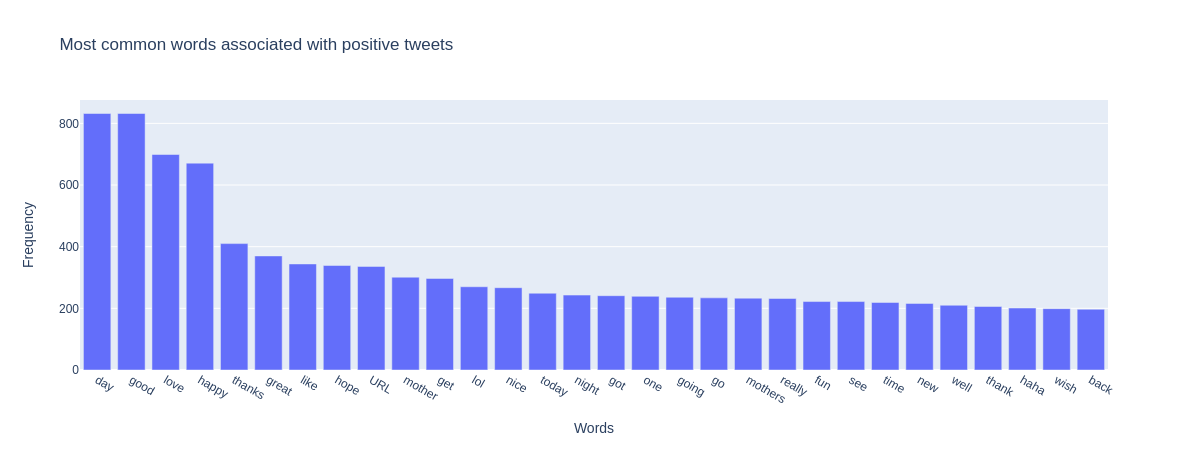

In [26]:
plot_freq_dist(create_corpus(pd.Series(positive_text_prepro)), title = 'Most common words associated with positive tweets')

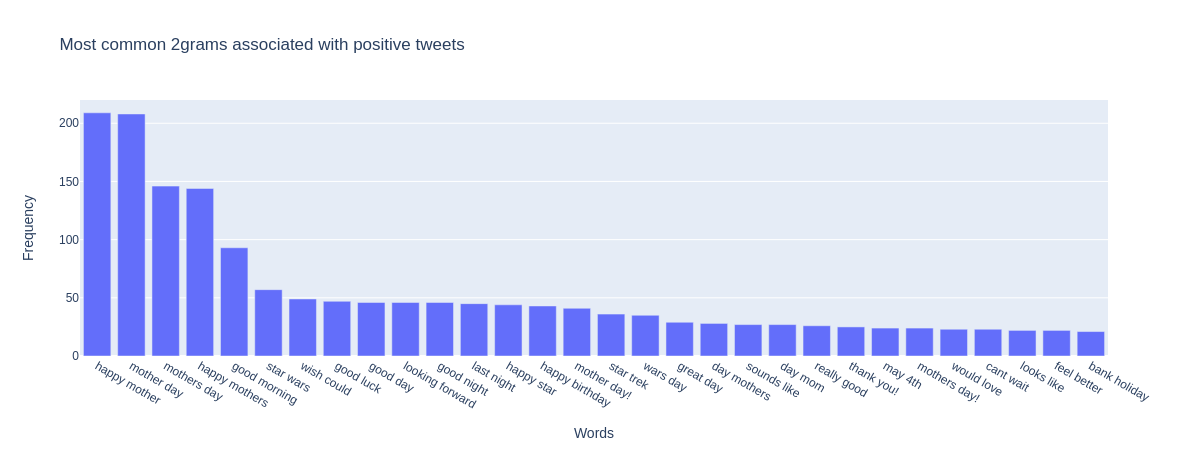

In [27]:
plot_freq_dist(create_corpus(pd.Series(positive_text_prepro)), ngram=2, title = 'Most common 2grams associated with positive tweets')

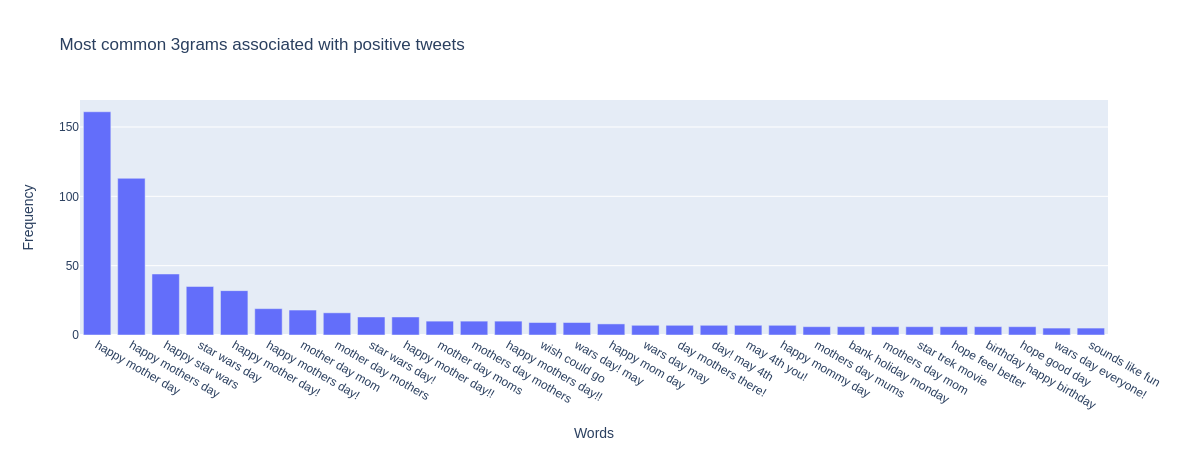

In [28]:
plot_freq_dist(create_corpus(pd.Series(positive_text_prepro)), ngram=3, title = 'Most common 3grams associated with positive tweets')

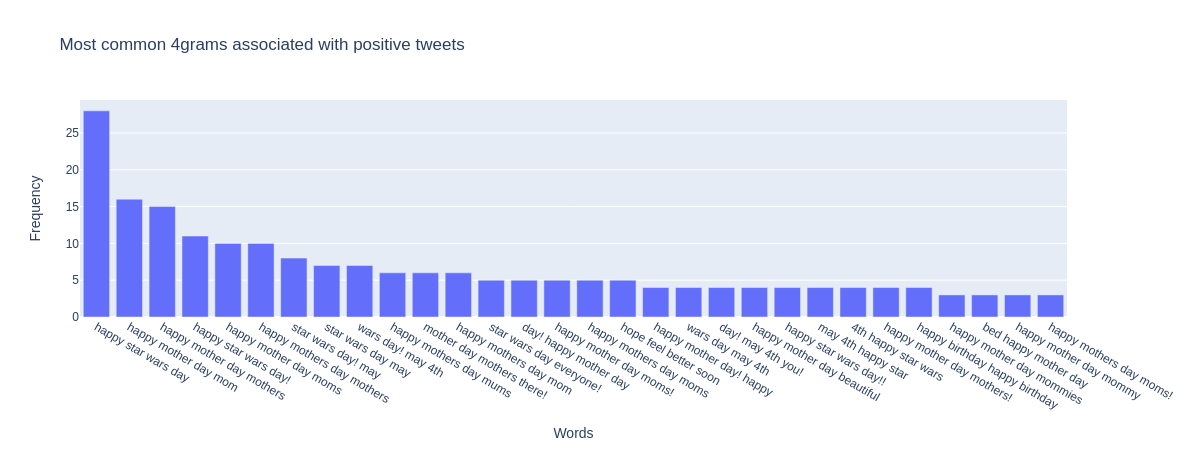

In [29]:
plot_freq_dist(create_corpus(pd.Series(positive_text_prepro)), ngram=4, title = 'Most common 4grams associated with positive tweets')

:::{admonition}[**insight**] :

Une grande majorité de tweets positifs se rapportent soit à la fête des mère, soit au 4 Mai du fait du jeu de mot avec Star Wars...

<div>
<img src=https://upload.wikimedia.org/wikipedia/fr/c/ca/LogoSW4th.png width="400"/>
</div>


Cette spécificité sera surement exploitée par les modèles comme un marqueur probable de tweets positifs.
:::

### Analyse des mots clefs des tweets neutres

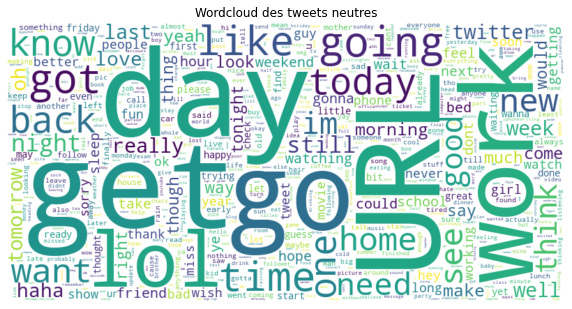

In [30]:
plotWc(" ".join(pd.Series(neutral_text_prepro)), stopwords=stopwords.words('english'), title = "Wordcloud des tweets neutres")

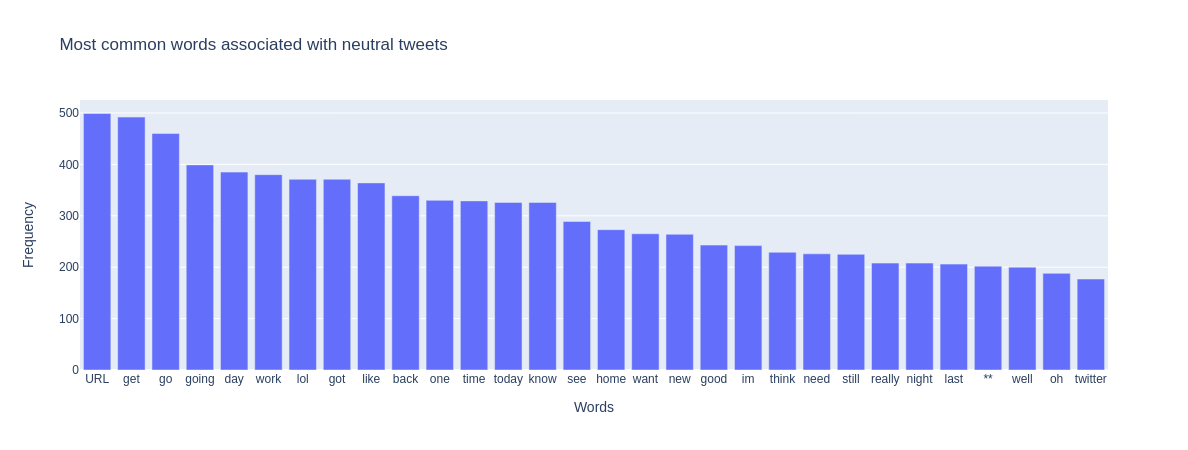

In [31]:
plot_freq_dist(create_corpus(pd.Series(neutral_text_prepro)), title = 'Most common words associated with neutral tweets')

:::{admonition}[**Insight**] :

On peut déjà remarquer que le mot `day`, qui est le plus fréquent des mots clefs des tweets positifs apparaît aussi en 6ème position des mots neutres.

:::

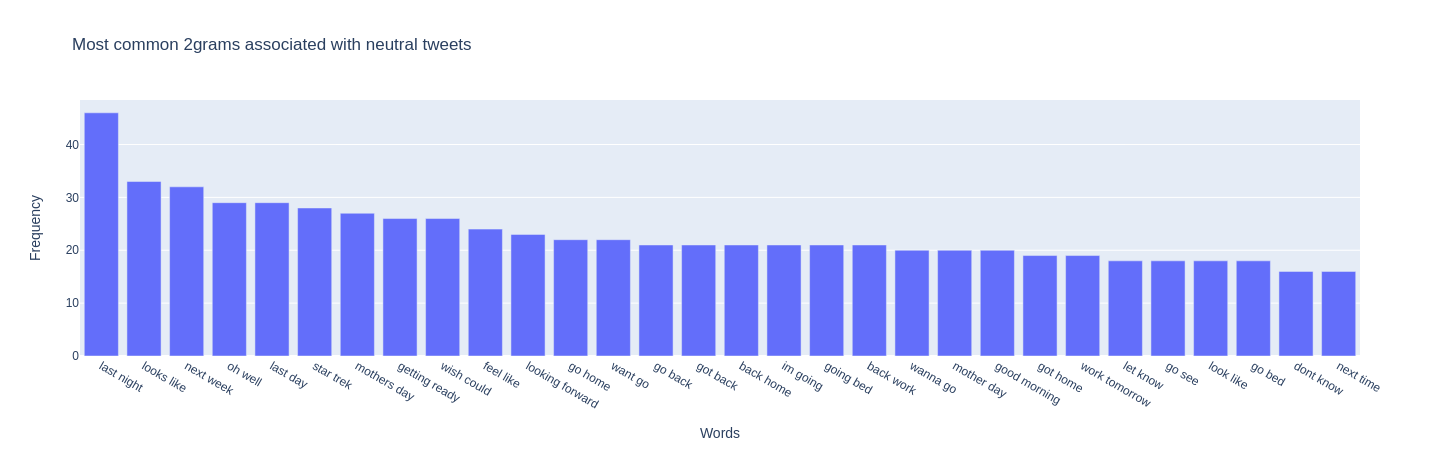

In [32]:
plot_freq_dist(create_corpus(pd.Series(neutral_text_prepro)), ngram=2, title = 'Most common 2grams associated with neutral tweets')

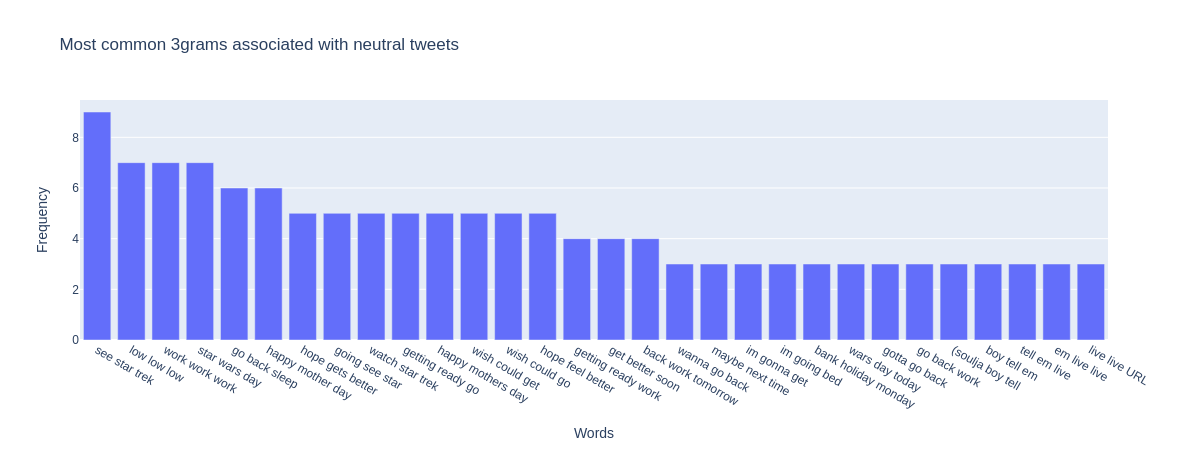

In [33]:
plot_freq_dist(create_corpus(pd.Series(neutral_text_prepro)), ngram=3, title = 'Most common 3grams associated with neutral tweets')

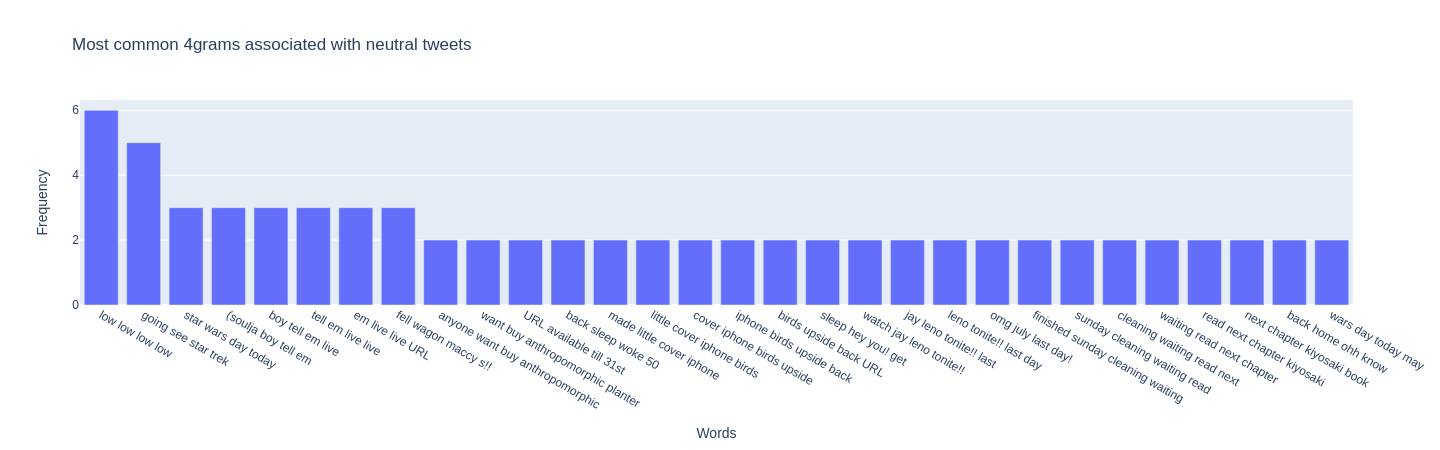

In [34]:
plot_freq_dist(create_corpus(pd.Series(neutral_text_prepro)), ngram=4, title = 'Most common 4grams associated with neutral tweets')

:::{admonition}[**insight**] : 

On voit une source de confusion arriver avec les tweets neutres dans la mesure où une proportion significative de ceux-ci se rapportent aussi à la fête des mères et star wars. 

:::

### Analyse des mots clefs des tweets négatifs

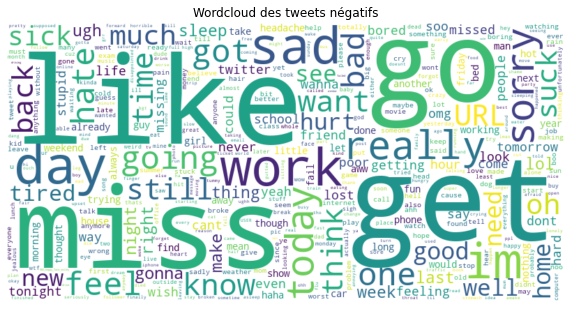

In [35]:
plotWc(" ".join(pd.Series(negative_text_prepro)), stopwords=stopwords.words('english'), title = "Wordcloud des tweets négatifs")

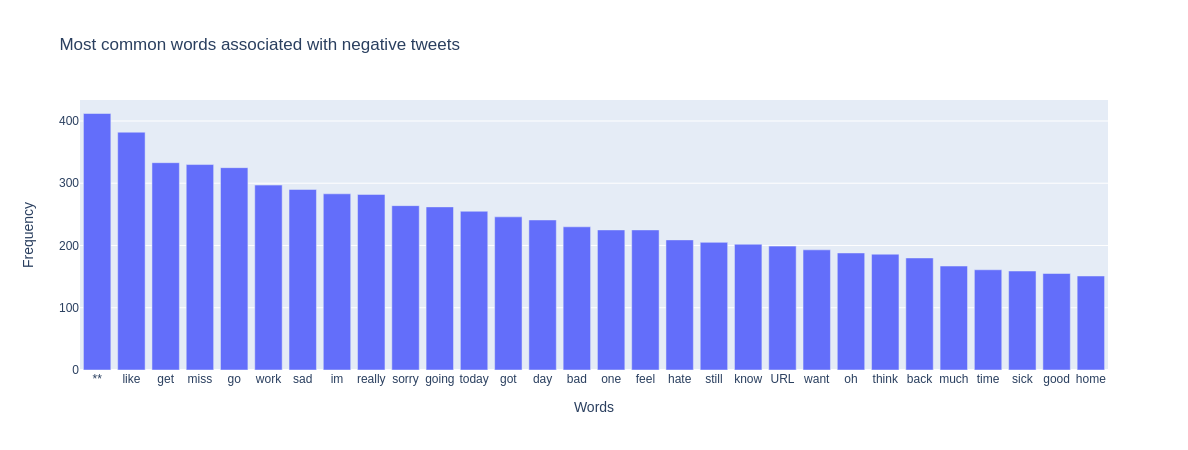

In [36]:
plot_freq_dist(create_corpus(pd.Series(negative_text_prepro)), title = 'Most common words associated with negative tweets')

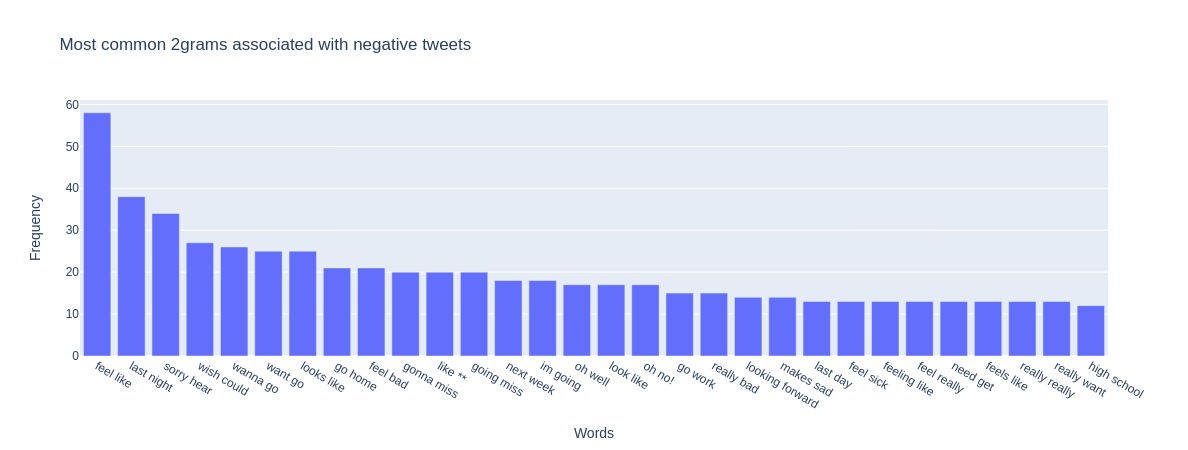

In [37]:
plot_freq_dist(create_corpus(pd.Series(negative_text_prepro)), ngram=2, title = 'Most common 2grams associated with negative tweets')

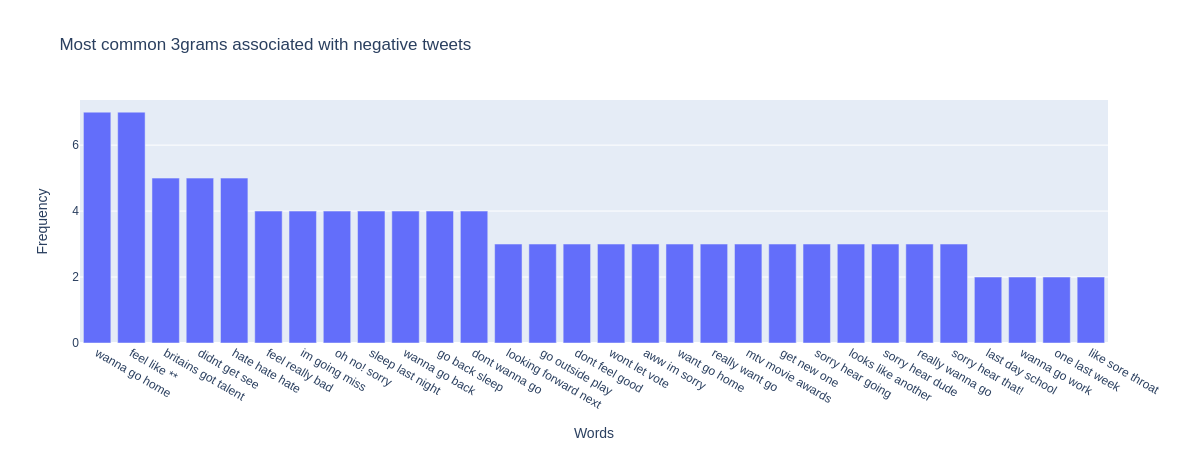

In [38]:
plot_freq_dist(create_corpus(pd.Series(negative_text_prepro)), ngram=3, title = 'Most common 3grams associated with negative tweets')

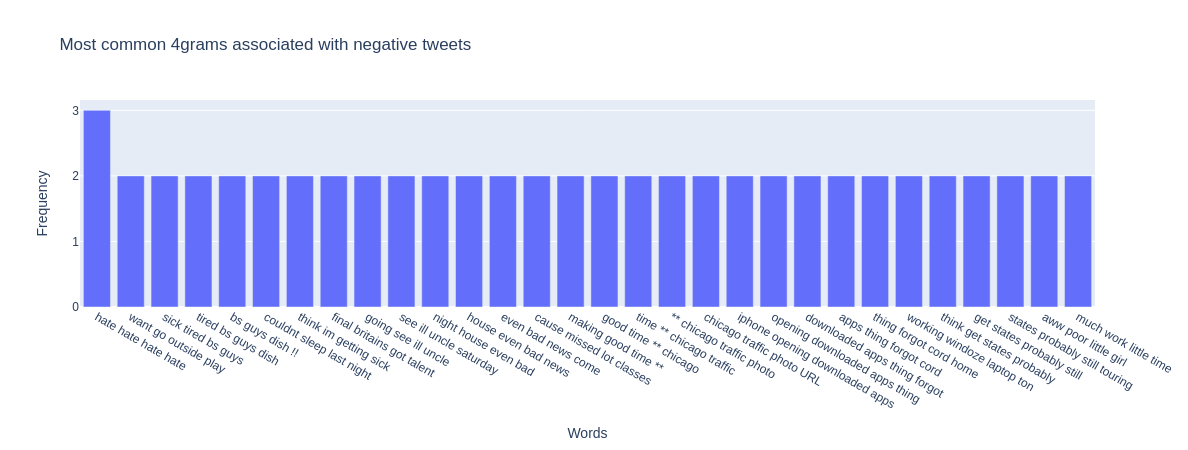

In [39]:
plot_freq_dist(create_corpus(pd.Series(negative_text_prepro)), ngram=4, title = 'Most common 4grams associated with negative tweets')

:::{admonition} [**insight**] : 

on observe l'utilisation de mots autocensurés (`**`) et de mots très chargés (`hate`)
Il ne servira à rien de tester des n-gram de dimension 4 ou plus : le nombre d'occurences est trop faible

:::

### Vérification : validation de l'occurence de certains patterns dans le texte

In [2]:
def list_words_with(text_series, search='', nb=30):
    '''
    Cette fonction permet de lister les mots dans un string qui contiennent une certaine chaîne de caractères
    
    inputs :
        - text_series : un pd.Series contennat les chaînes de caractères
        - search : la séquence à rechercher
        - nb : ressortir les nb occurences les plus fréquentes
    
    output :
        - une liste de tuples contenant 
            + le mot contenant la séquence recherchée
            + le nombre d'occurence dans text_series
    
    '''
    
    
    #searchPattern   = f"\w*{search}\w*"
    searchPattern   = f"\w*{search}\w* "
    
    cnt = Counter()
    
    for tweet in text_series:
        # Replace all URls with 'URL'
        tweet = re.findall(searchPattern,tweet)
        for word in tweet:
            cnt[word] += 1
    return cnt.most_common(nb)
    

In [43]:
#liste des mots incluant auto-censure **
list_words_with(negative_text_prepro, search='\*{2}')

[('** ', 412),
 ('_megan_** ', 2),
 ('bl**y ', 1),
 ('**i ', 1),
 ('_da_** ', 1),
 ('j**i ', 1),
 ('_** ', 1),
 ('f** ', 1),
 ('p**ed ', 1),
 ('f**in ', 1)]

In [44]:
#nombre d'utilisateurs
list_words_with(negative_text_prepro, search='USER')

[('USER ', 21)]

In [45]:
#nombre d'URLs
list_words_with(negative_text_prepro, search='URL')

[('URL ', 199)]

In [46]:
#liste des émojis
list_words_with(negative_text_prepro, search='EMO\w+')

[('EMO_Happy_face_smiley ', 19),
 ('EMO_Skeptical_annoyed_undecided_uneasy_or_hesitant ', 18),
 ('EMO_Tongue_sticking_out_cheeky_playful_or_blowing_a_raspberry ', 18),
 ('EMO_Frown_sad_andry_or_pouting ', 11),
 ('EMO_Surprise ', 10),
 ('EMO_Sealed_lips_or_wearing_braces_or_tongue ', 1),
 ('EMO_Embarrassed_or_blushing ', 1),
 ('EMO_Shock ', 1),
 ('EMO_Sad_or_Crying ', 1)]

In [47]:
#les mots qui incluents !!
list_words_with(negative_text_prepro, search='!!')

[('!! ', 54),
 ('me!! ', 13),
 ('sucks!! ', 8),
 ('you!! ', 6),
 ('it!! ', 6),
 ('today!! ', 6),
 ('up!! ', 6),
 ('again!! ', 5),
 ('now!! ', 5),
 ('ugh!! ', 4),
 ('that!! ', 4),
 ('hurts!! ', 4),
 ('sleep!! ', 4),
 ('noo!! ', 4),
 ('starving!! ', 3),
 ('bed!! ', 3),
 ('time!! ', 3),
 ('too!! ', 3),
 ('home!! ', 3),
 ('show!! ', 3),
 ('sorry!! ', 3),
 ('omg!! ', 3),
 ('work!! ', 3),
 ('wtf!! ', 3),
 ('one!! ', 3),
 ('out!! ', 3),
 ('blows!! ', 2),
 ('night!! ', 2),
 ('top!! ', 2),
 ('no!! ', 2)]

In [48]:
#les tweets complets qui incluent 'bs' (apparaît dans les 4grams)
list_words_with(negative_text_prepro, search='[\w ]* bs [\w ]*')

[('soo   kinda  sick  tired   bs  guys dish  ', 1),
 ('soo   kind  sick  tired   bs  guys dish  ', 1),
 ('fudge  bs   whole paper  tired ugh  hate school time  ', 1)]

In [49]:
#listing des mots clefs
list_words_with(negative_text_prepro, search='#[(\w*|\d*)]+')

[('#bgt ', 8),
 ('#fail ', 5),
 ('#fb ', 5),
 ('#itsucks ', 3),
 ('#followfriday ', 3),
 ('#fieldnotes ', 2),
 ('#sad ', 2),
 ('#beatwittyparty ', 2),
 ('#fixreplies ', 2),
 ('#ff ', 2),
 ('#liesboystell ', 2),
 ('#frustraded ', 2),
 ('#2 ', 2),
 ('#hunchback ', 1),
 ('#screengrab09 ', 1),
 ('#obs ', 1),
 ('#comet09 ', 1),
 ('#tcot ', 1),
 ('#antiboyle ', 1),
 ('#2923848932 ', 1),
 ('#linux ', 1),
 ('#ubuntu ', 1),
 ('#nontweetinggirlfriend ', 1),
 ('#brandwkshop ', 1),
 ('#beta1 ', 1),
 ('#livescribe ', 1),
 ('#luto ', 1),
 ('#rip ', 1),
 ('#rda2009cla ', 1),
 ('#britainsgottalent ', 1)]

In [50]:
def user_names(text_list):
    cnt = Counter()
    for text in text_list:
        for word in text.split():
            if word.startswith('@'):
                cnt[word] += 1
    return cnt
    

In [51]:
user_names(positive_text)

Counter({'@_agressiva23': 1,
         '@_TWEE': 1,
         '@': 44,
         '@_Mintyfresh': 1,
         '@_josh_thomas': 1,
         '@_catchfire': 1,
         '@_elj': 2,
         '@_Flik_': 1,
         '@_writersblock_': 1,
         '@_chloe': 1,
         '@_anh': 1,
         '@_mamalaura': 1,
         '@_careerbuilder_': 1,
         '@_Bella_Cullen13': 1,
         '@>--->--->---': 1,
         '@-)': 2,
         '@_AlexaJordan': 1,
         '@_everblue': 1,
         '@_everaldo': 1})

In [52]:
user_names(positive_text_prepro)

Counter()

In [53]:
user_names(negative_text_prepro)

Counter()

In [54]:
user_names(neutral_text_prepro)

Counter()

## Sortie des données préprocessées pour l'analyse

In [67]:
X_train_prepro=pd.DataFrame(columns=['text'])
X_val_prepro=pd.DataFrame(columns=['text'])
X_test_prepro=pd.DataFrame(columns=['text'])

X_train_prepro['text'] = preprocess_text(X_train['text'], apply_lemmatizer=False, apply_non_alphabetical_removal=True)
X_val_prepro['text'] = preprocess_text(X_val['text'], apply_lemmatizer=False, apply_non_alphabetical_removal=True)
X_test_prepro['text'] = preprocess_text(X_test['text'], apply_lemmatizer=False, apply_non_alphabetical_removal=True)

In [65]:
X_train_prepro

text
0                                    responded    going 
1                         soo sad   miss    san diego!! 
2                                       boss  bullying  
3                               interview! leave  alone 
4          sons  **     put    releases  already bought 
...                                                  ...
21979   allowed  calculator   exam despite  containin...
21980                                      haha   miine 
21981    sorry people   rude   isaac   get  manners  ...
21982    enjoy fancy meals    smtimes thr  joy  solit...
21983          oh yeah love  choregoraphy  pants   much 

[21984 rows x 1 columns]

In [68]:
# Données explicatives
X_train_prepro.to_parquet('/mnt/data/interim/X_train_prepro.gzip',compression='gzip')
X_val_prepro.to_parquet('/mnt/data/interim/X_val_prepro.gzip',compression='gzip')
X_test_prepro.to_parquet('/mnt/data/interim/X_test_prepro.gzip',compression='gzip')